<a href="https://colab.research.google.com/github/joowop/Metaverse_AI_Project/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:12<00:00, 91.1MB/s]
100% 1.33G/1.33G [00:13<00:00, 110MB/s] 


In [5]:
!unzip celeba-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/197620.jpg  
  in

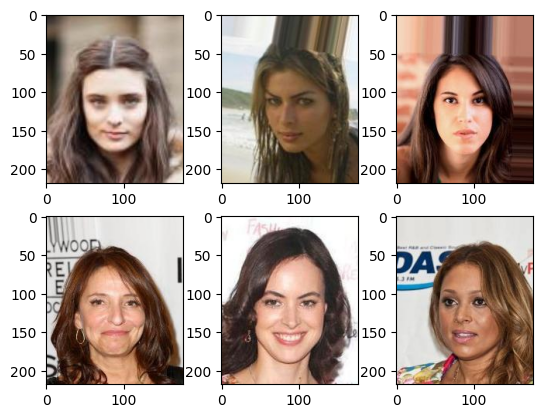

In [6]:
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

imgs = glob.glob('./img_align_celeba/img_align_celeba/*.jpg')

for i in range(6):
    plt.subplot(2,3,i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)

In [7]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

In [8]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = ImageFolder(
    root = './img_align_celeba/',
    transform = transforms
)

loader = DataLoader(dataset , batch_size=128, shuffle=True)

128


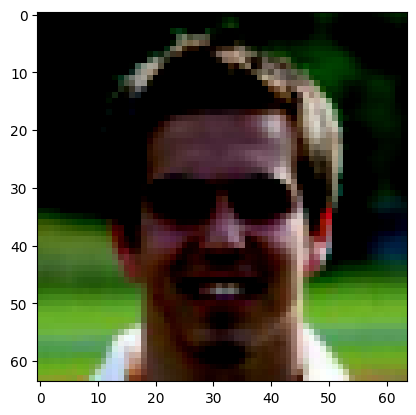

In [9]:
import numpy as np

img,label = next(iter(loader))
print(len(img))
img = img[0].numpy()
plt.imshow(np.transpose(img,(1,2,0)))

In [23]:
# 생성자 generator

import torch.nn as nn

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100,512,kernel_size=4,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )

    def forward(self,x):
        return self.gen(x)

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.disc = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512,1,kernel_size=4),
            nn.Sigmoid()
        )


    def forward(self,x):
        return self.disc(x)

In [27]:
# 가중치 초기화
def weights_init(m):
    classname = type(m).__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weights.data,0.0,0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [28]:
import tqdm
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

G_optim = Adam(G.parameters() , lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters() , lr=0.0001, betas=(0.5, 0.999))

cuda


In [29]:
for epochs in range(20):
    iterator = tqdm.tqdm(enumerate(loader,0), total=len(loader))

    for i,data in iterator:
        D_optim.zero_grad()

        label = torch.ones_like(data[1] , dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)

        #진짜 이미지를 1로 판별
        real = D(data[0].to(device))
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()

        noise = torch.randn(label.shape[0], 100,1,1, device=device)
        fake = G(noise)

        output = D(fake.detach())
        Dloss_fake = nn.BCELoss()(torch.squeeze(output),label_fake)
        Dloss_fake.backward()

        Dloss = Dloss_real + Dloss_fake
        D_optim.step()

        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output),label)
        Gloss.backward()

        G_optim.step()

        iterator.set_description(f'epoch: {epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}')


    torch.save(G.state_dict(), 'Generator.pth')
    torch.save(D.state_dict(), 'Discriminator.pth')


epoch: 0 iteration:1582 D_loss:0.13088873028755188 G_loss:4.473090171813965: 100%|██████████| 1583/1583 [07:50<00:00,  3.37it/s]
epoch: 1 iteration:1582 D_loss:0.0974225401878357 G_loss:4.565876007080078: 100%|██████████| 1583/1583 [07:48<00:00,  3.38it/s]
epoch: 2 iteration:1582 D_loss:0.16234347224235535 G_loss:3.483891010284424: 100%|██████████| 1583/1583 [07:45<00:00,  3.40it/s]
epoch: 3 iteration:1582 D_loss:0.17012056708335876 G_loss:4.457037925720215: 100%|██████████| 1583/1583 [07:36<00:00,  3.47it/s]
epoch: 4 iteration:1582 D_loss:0.1978585571050644 G_loss:5.3351030349731445: 100%|██████████| 1583/1583 [07:26<00:00,  3.55it/s]
epoch: 5 iteration:1582 D_loss:0.08771699666976929 G_loss:4.415173053741455: 100%|██████████| 1583/1583 [07:27<00:00,  3.54it/s]
epoch: 6 iteration:1582 D_loss:0.1382809579372406 G_loss:4.438141822814941: 100%|██████████| 1583/1583 [07:32<00:00,  3.50it/s]
epoch: 7 iteration:1582 D_loss:0.1227506771683693 G_loss:3.5381016731262207: 100%|██████████| 1583/

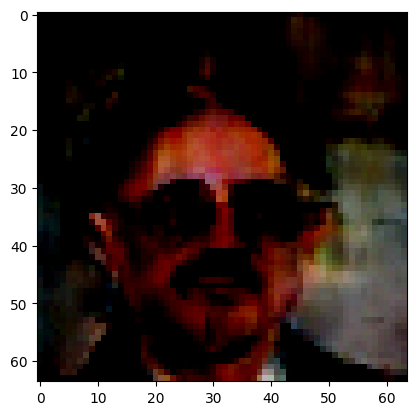

In [41]:
import matplotlib.pyplot as plt
from PIL import Image

with torch.no_grad():
    G.load_state_dict(torch.load('Generator.pth',map_location=device))
    feature_vector = torch.randn(1,100,1,1).to(device)
    pred = G(feature_vector).squeeze()
    pred = pred.permute(1,2,0).cpu().numpy()

    plt.imshow(pred)
    plt.show()
